## Background

---

<div class="alert alert-block alert-info">
<b>Stages in Building LLM from scratch</b> 
<p>   

Below are the stages of building LLM from scratch


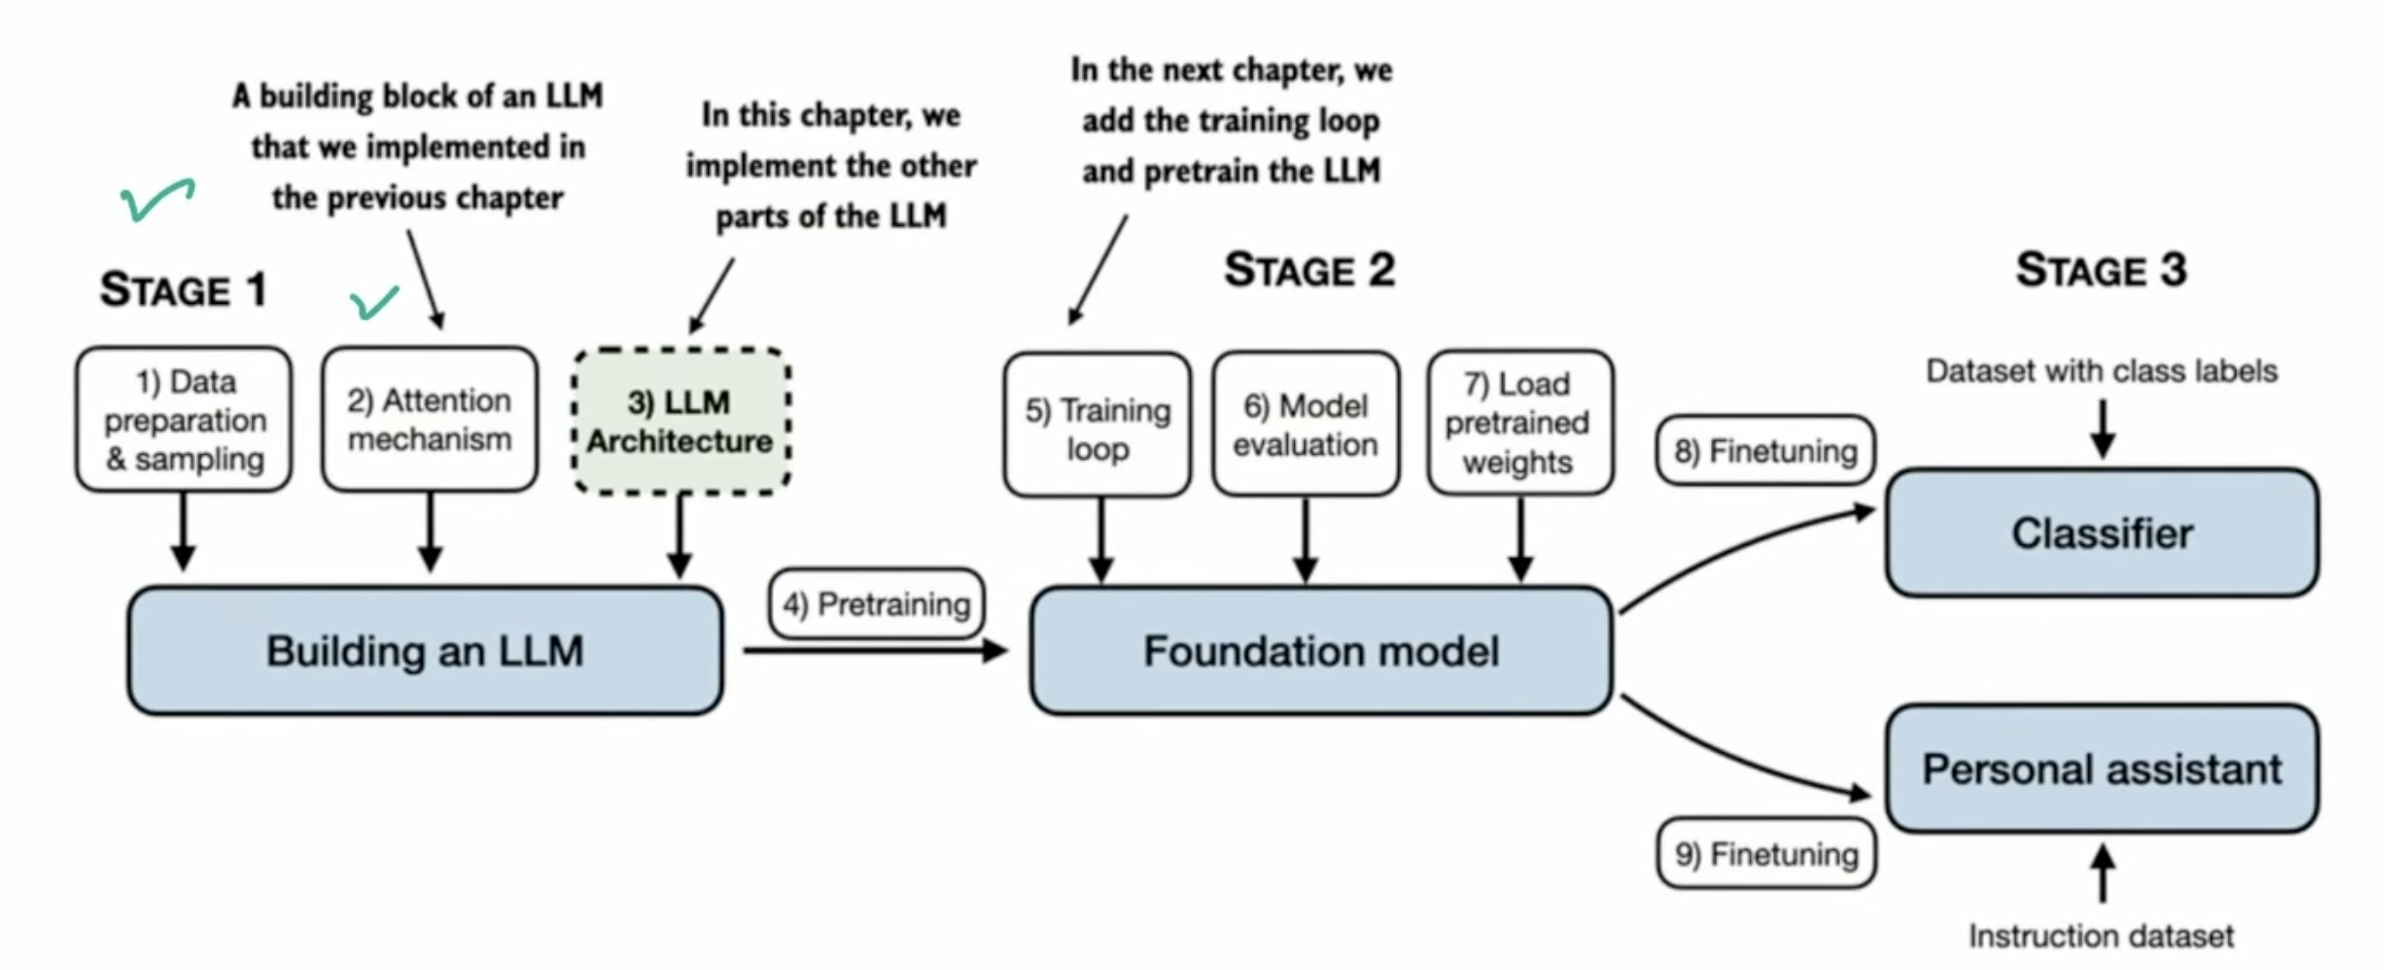



</p>
</div>





<div class="alert alert-block alert-info">
<b>Lets See the flow and building blocks of the LLM</b> 
<p>   

As your see from below the sequence

1. We give input sequence (E.g "Every efforts moves you")
2. Then we <font color=blue> tokenize </font> this input sequence using <font color=blue> Byte-Pair Encoding algorithm </font>
3. This Tokenized input is converted into <font color=blue> Embedded Vector + Positional Embedding Vector </font>
4. This Embedding vectors is then converted using <font color=blue> Context Vectors </font> with the help of <font color=blue> Masked multi-head Attention </font>
5. These Context Vector are <font color=blue> enriched vector </font> that contains semantic and details of how the token is related to other tokens in input sequence walong with the Weightable
6. Next comes the <font color=blue> Transformer Block </font> . This is the most important part of LLm architecture
7. The <font color=blue> output from transformer </font> is then decoded to predict the next word
   

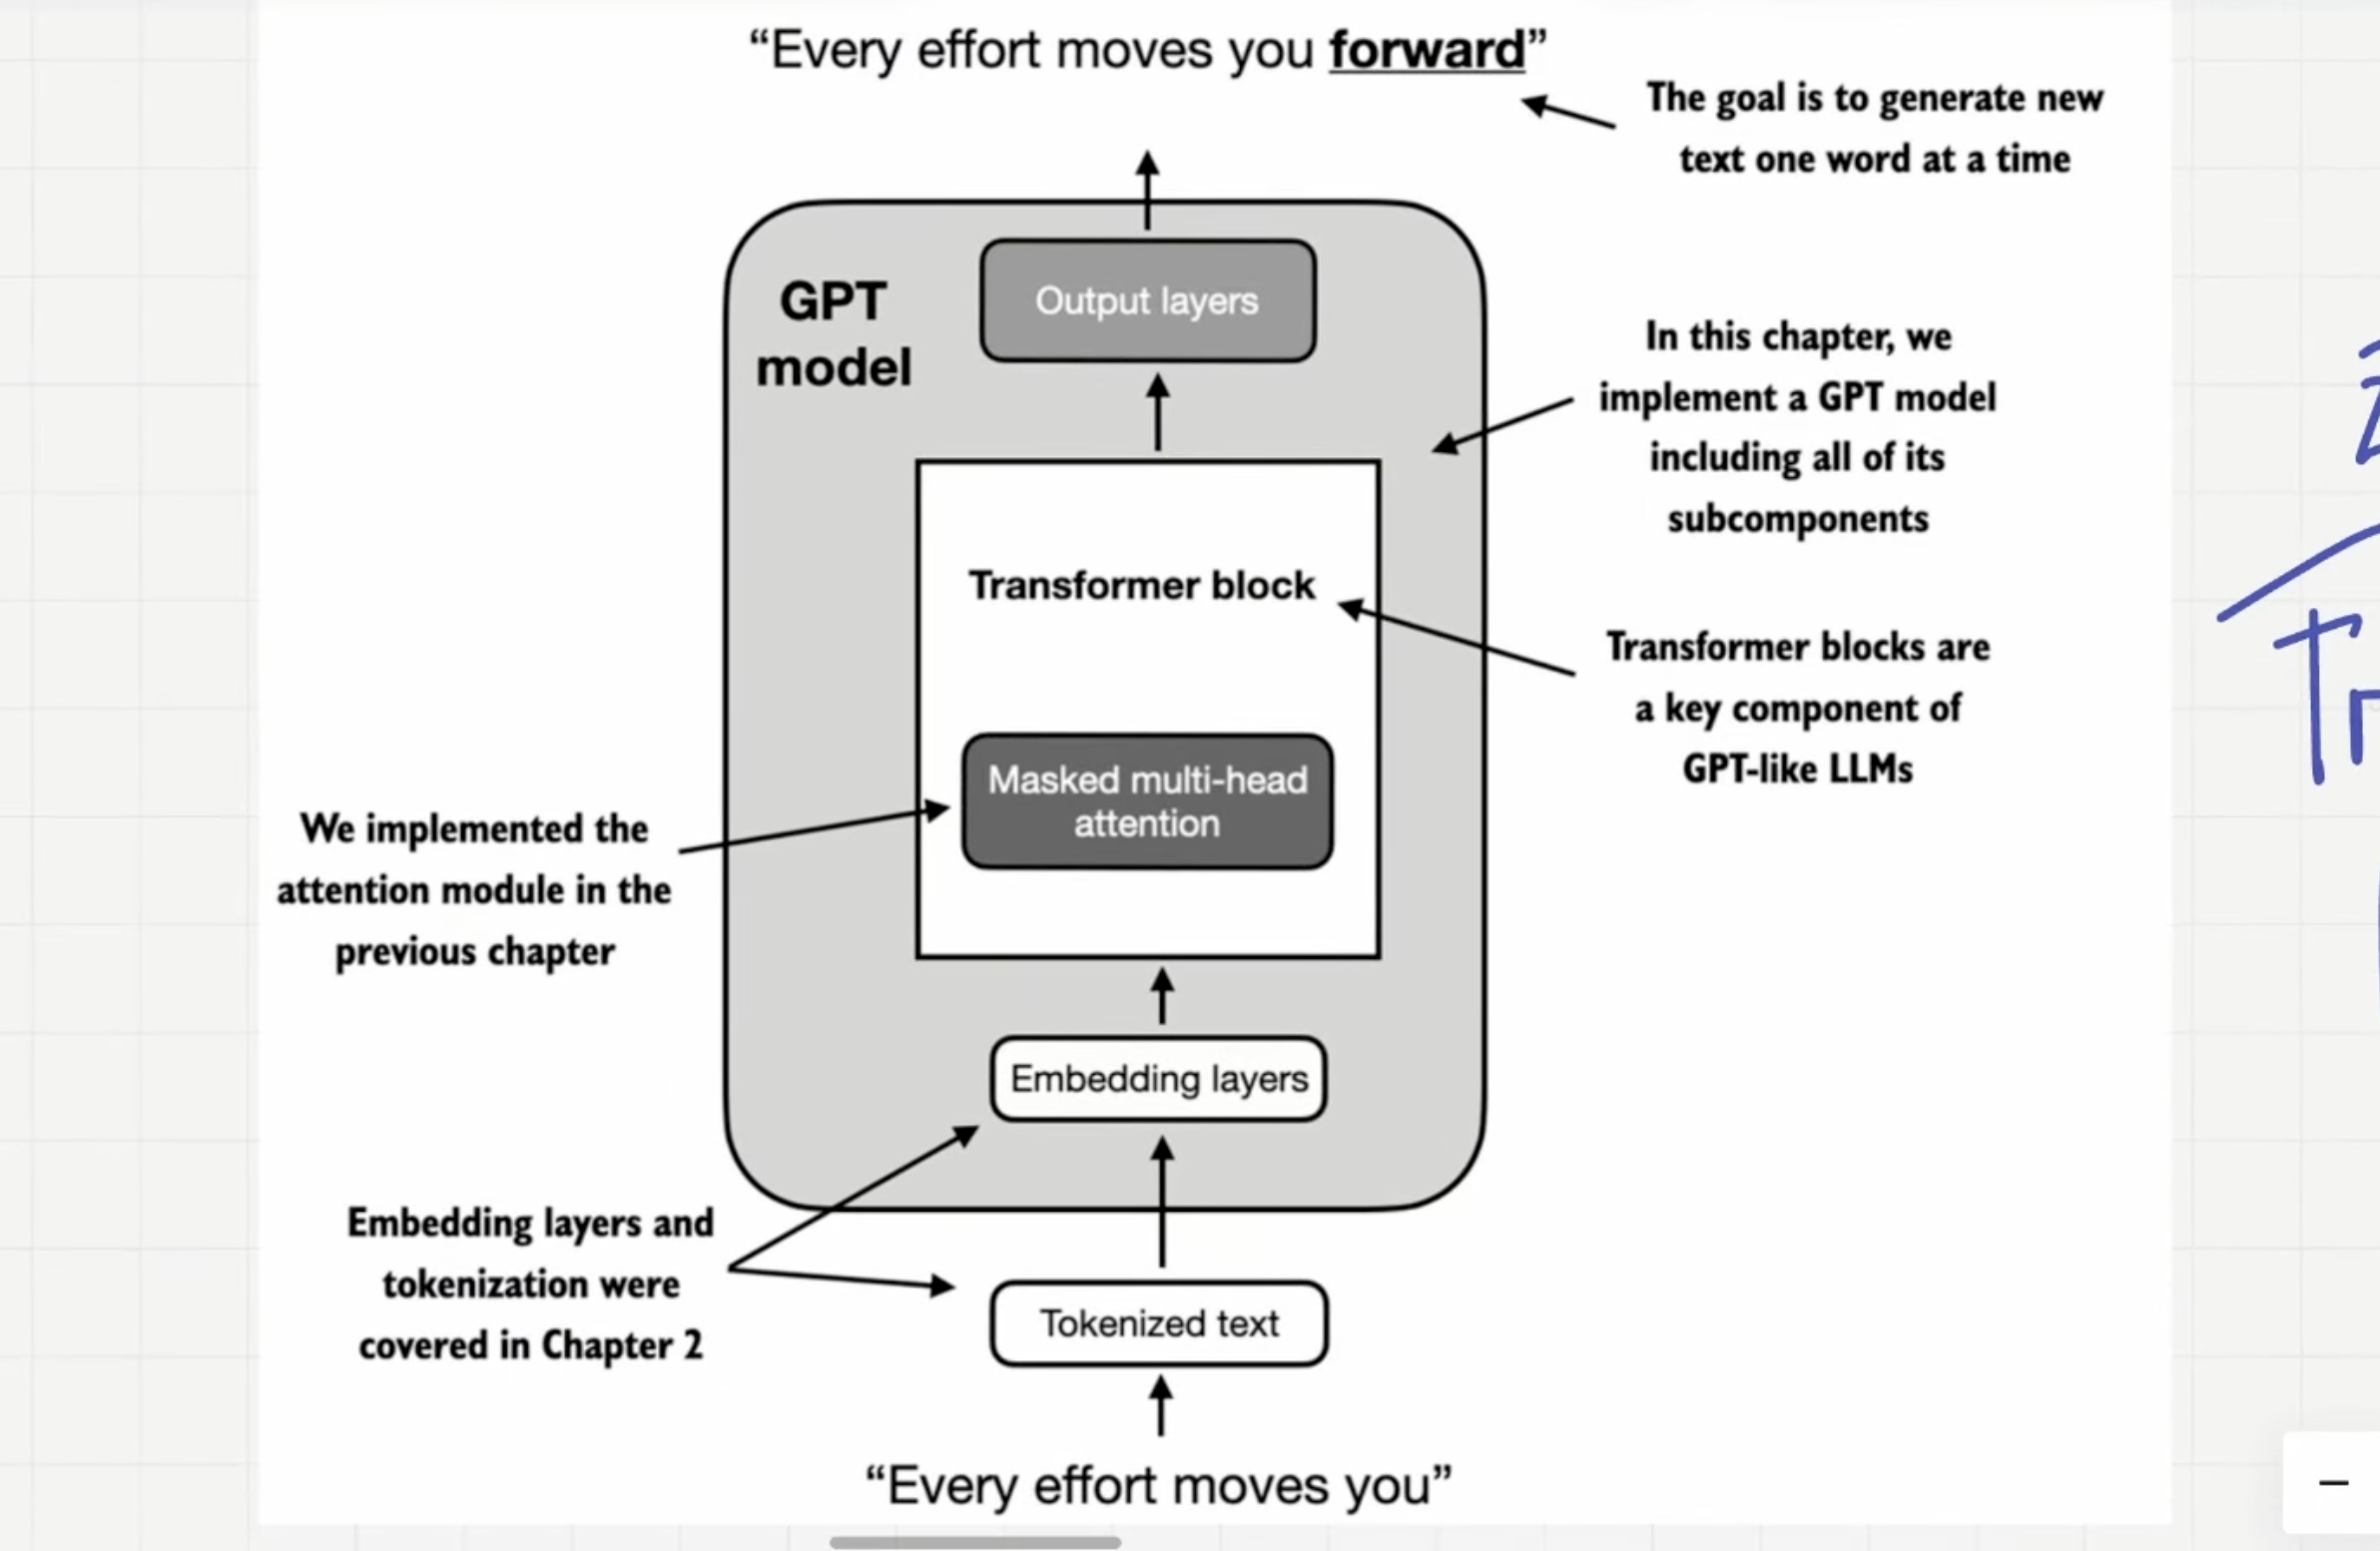



</p>
</div>




### GPT ARCHITECTURE : Dummy GPT MODEL CLASS

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        # this is the layer to convert the vector output to Logits vector 
        # of size batch * Context length * vocab_size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # Embedd the tokesn to higher dimensional space
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device)) # get Pos Embedding
        x=tok_embeds + pos_embeds # Combine the Token Embeds with its position embeds
        x=self.drop_emb(x)   # Perform Droput 
        x=self.trf_blocks(x)
        x= self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


In [4]:
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

---

# Part 4 : Assemble all components in transformer Block

# `Lets code the entire Transformer Block`

---

<div class="alert alert-block alert-success">
<b> Chat GPT paramters</b> 
</div>

In [9]:
# Lets define the confoguration for GPT Model
# We planning to build the GPT Model with 124M parameters. This is the small GPT version

GPT_CONFIG_124M = {
  "vocab_size"     : 50257, # BPE encoding has the vocab size of 50257
  "context_length" : 1024,  # number of token we can look at ones to predict new word
  "emb_dim"        : 768,   # The Toekn Embedding dimension
  "n_heads"        : 12,    # number of attention heads
  "n_layers"       : 12,    # Number of layers (Transformer blocks)
  "drop_rate"      : 0.1,   # Dropout Rate
  "qkv_bias"       : False  # Quert-Key-Value Bias
}

<div class="alert alert-block alert-success">
<b> Multihead attention</b> 
</div>

In [10]:
import torch
import torch.nn as nn
import numpy as np

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out ,context_length , dropout , num_heads , qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0) , f"d_out should be divisible by num_heads"

        self.d_out= d_out
        self.num_heads = num_heads
        self.head_dim= d_out // num_heads # check above for the explaination (10. Multi-head attention Part 2)
        
        # Here we have initialixed the Weight Matrices with larger dimensions already
        # This if to perform operations and then split to its respect heads based on value num_head
        # So in this example we decide d_out = 6 , hence with num_heads =2 , we will have 2 heads (causal attentions) with 3 dimension each
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        
        self.dropout= nn.Dropout(dropout)
        self.register_buffer("mask" ,
                             torch.triu(torch.ones(context_length , context_length),
                             diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape

        #print("Dimension of Weight Matrice before inputs operation" , self.W_value.weight.shape , "\n")
        # this gives us the 3 * 6 Weight matrices
        queries = self.W_key(x)
        keys    = self.W_query(x)
        values  = self.W_value(x)
        #print("Dimension of Weight Matrice after inputs operation:" , values.shape , "\n")
        #print("Values of Weight Matrice after inputs operation: \n" , values , "\n")

        # We implicitly split the matrix by adding a `num_heads` dimension
        # reshape the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        # basically we just reshaping it per token , per head  (group by tokens)
        keys = keys.reshape(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.reshape(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.reshape(b, num_tokens, self.num_heads, self.head_dim)
        
        #print("Dimension of Weight Matrice after Reshape operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Reshapr operation: \n" , values, "\n")

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # This is required becuase we want to perform multiplication operation between data (token and dimesnion)
        # so we get the data that is tokens  and embedding at rthe end
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        #print("Dimension of Weight Matrice after Grouping by Head operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Grouping by Head  operation: \n" , values, "\n")

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Now attn score dimension is (batch , head_num , tokens , head_dim)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        #print("Dimension of Attention cores Matrice :" , attn_scores.shape, "\n") 
        #print("Values of Attention cores Matrice: \n" , attn_scores, "\n")

        
        # Original mask truncated to the number of tokens and converted to boolean
        # this is tghe edge case , if there are token less then context length (end of datasets)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        #print("Values of Masked Boolean Matrix: \n" , mask_bool, "\n")

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        #print("Values of Masked Attention cores Matrice: \n" , attn_scores, "\n")

        # Perform the normalization
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Perform the droput
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        #context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-success">
<b> Layer Normalization</b> 
</div>

In [12]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))


    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1 , keepdim=True , unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var+self.eps)
        print(norm_x)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-success">
<b> Gelu Activation Function</b> 
</div>

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        activation = 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

        return activation

<div class="alert alert-block alert-success">
<b> Feed Forward Network</b> 
</div>

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Define 1st layer with input and o/p size . Expansion
            GELU(),                                        # Define the Activation function
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # define the final layer . Contraction
        )

    def forward(self, x):
        return self.layers(x)
    

<div class="alert alert-block alert-success">
<b> Let put all this Layers to Transformer Block</b> 
</div>

<div class="alert alert-block alert-info">
<b>Keep This Block and all the Components in Mind</b> 
<p>   

We are working on build This block and stack all the components in the blocks 
   
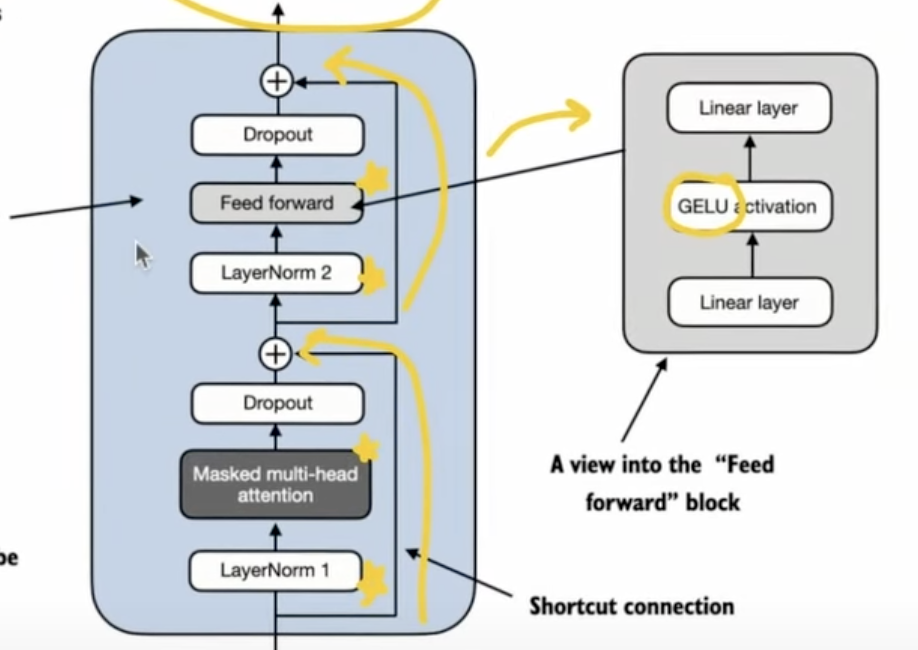



</p>
</div>




In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)  # As seen in pic , this is LayerNorm1 (from bottom)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] , This is Block 2
        x = self.drop_shortcut(x) # Then Dropout Block 3 (from bottom)
        x = x + shortcut  # Add the original input back (shortcut )

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x) 
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [16]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

tensor([[[-0.7116,  0.0561, -0.8664,  ...,  1.5799,  1.2408, -0.1394],
         [-0.9234, -0.6553, -0.6646,  ...,  0.1473, -0.1622,  0.8549],
         [ 0.6713, -0.8855, -0.3164,  ...,  1.3311, -0.0421,  0.3291],
         [-1.4209,  0.9115,  1.3900,  ..., -0.2009,  0.4232,  0.2464]],

        [[ 0.3018,  1.5416, -0.5013,  ..., -1.5116, -0.0970, -0.7085],
         [-1.3702, -0.9242, -0.3665,  ..., -0.3169, -0.1082, -0.1112],
         [ 0.6008, -1.1332, -1.0154,  ...,  0.1780,  0.3063, -1.4019],
         [-0.3778, -0.3127, -1.4921,  ...,  1.6788,  1.4997, -1.2653]]])
tensor([[[-0.6864,  0.0635, -1.1892,  ...,  1.8410,  0.1033, -0.0057],
         [-0.6551, -0.9024, -0.5028,  ...,  0.4286, -0.7044,  0.7176],
         [ 0.4613, -0.6976, -0.9408,  ...,  0.8427, -0.7045,  0.3616],
         [-1.0546,  0.5011,  1.1622,  ..., -0.6394,  0.3703,  0.5426]],

        [[-0.3319,  1.1361, -0.4302,  ..., -0.7712, -0.9412, -1.7202],
         [-0.9563,  0.1751,  0.1061,  ..., -0.5898,  0.3945, -0.6676],
